In [1]:
import torch
import geomloss
import torch.nn.functional as F
from geomloss import SamplesLoss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --- Fonctions utilitaires ---

def _downsample_to_resolution(img: torch.Tensor, target_res):
    """
    img : (3, H, W)
    target_res :
      - int   -> on fixe le plus grand côté à target_res (ratio conservé)
      - tuple -> (H_target, W_target) directement
    """
    C, H, W = img.shape
    assert C == 3

    if isinstance(target_res, int):
        max_side = max(H, W)
        if max_side == target_res:
            return img
        scale = target_res / max_side
        new_H = max(1, int(round(H * scale)))
        new_W = max(1, int(round(W * scale)))
        size = (new_H, new_W)
    else:
        # on suppose (H_target, W_target)
        size = target_res

    img_b = img.unsqueeze(0)  # (1,3,H,W)
    img_ds = F.interpolate(img_b, size=size, mode="bilinear", align_corners=False)
    return img_ds.squeeze(0)  # (3, H_new, W_new)


def _channel_to_measure(img_c: torch.Tensor, device=None):
    """
    img_c : (H, W), intensités >= 0 (ex: 0–255 ou 0–1)
    Retourne :
      - positions : (N, 2) dans [0,1]^2
      - weights   : (N,) (non normalisées)
    """
    if device is None:
        device = img_c.device

    H, W = img_c.shape
    ys = torch.linspace(0.0, 1.0, H, device=device)
    xs = torch.linspace(0.0, 1.0, W, device=device)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")  # (H,W)

    positions = torch.stack([xx, yy], dim=-1).reshape(-1, 2)  # (N,2)
    weights = img_c.reshape(-1).clamp(min=0)

    return positions, weights


def rgb_unbalanced_sinkhorn(c
    img1: torch.Tensor,
    img2: torch.Tensor,
    res1,
    res2,
    blur=0.02,
    reach=0.1,
    p=2,
    debias=True,
    return_potentials=False,
    device="cpu",
    backend="tensorized",
):
    """
    img1, img2 : torch.Tensor
        - soit (H, W, 3)
        - soit (3, H, W)
        valeurs >= 0 (0–1 ou 0–255), on ne normalise pas les intensités.
    res1 : résolution pour img1 (int ou (H1,W1))
    res2 : résolution pour img2 (int ou (H2,W2))
    blur  : sigma telle que eps = blur^p
    reach : tau telle que rho = reach^p  (unbalanced)
    p     : exponent du coût (1 ou 2 en pratique)
    debias : utilise la Sinkhorn divergence dé-biaisée
    return_potentials : si True, retourne aussi (f,g) par canal
    backend : "tensorized", "online", etc. (ici "tensorized" par défaut)
    Retour :
      {
        "losses": {
            "R": float,
            "G": float,
            "B": float,
        },
        "potentials": None
           ou {
               "R": {"f1": (H1_res1,W1_res1), "g2": (H2_res2,W2_res2)},
               "G": {...},
               "B": {...},
           }
      }
    """

    # Mise en forme des images
    if img1.dim() == 3 and img1.shape[-1] == 3:
        img1 = img1.permute(2, 0, 1)  # (3,H,W)
    if img2.dim() == 3 and img2.shape[-1] == 3:
        img2 = img2.permute(2, 0, 1)

    img1 = img1.to(device).float()
    img2 = img2.to(device).float()

    assert img1.shape[0] == 3 and img2.shape[0] == 3, "Images must be RGB (3 channels)."

    # Downsample à la résolution demandée
    img1_ds = _downsample_to_resolution(img1, res1)  # (3,H1r,W1r)
    img2_ds = _downsample_to_resolution(img2, res2)  # (3,H2r,W2r)

    C1, H1r, W1r = img1_ds.shape
    C2, H2r, W2r = img2_ds.shape
    assert C1 == 3 and C2 == 3

    colors = ["R", "G", "B"]
    losses = {c: 0.0 for c in colors}
    potentials = {} if return_potentials else None

    # On crée une factory de loss pour pouvoir activer ou non potentials
    def make_loss(potentials_flag: bool):
        return SamplesLoss(
            loss="sinkhorn",
            p=p,
            blur=blur,
            reach=reach,
            # On ne débiaise pas pour récupérer les potentiels
            debias=debias and not potentials_flag,
            backend=backend,
            potentials=potentials_flag,
        )

    # --- Calcul des coûts par canal ---
    for ch_idx, color in enumerate(colors):
        ch1 = img1_ds[ch_idx]  # (H1r,W1r)
        ch2 = img2_ds[ch_idx]  # (H2r,W2r)

        x1, a1 = _channel_to_measure(ch1, device=device)
        x2, a2 = _channel_to_measure(ch2, device=device)

        loss_fn = make_loss(potentials_flag=False)
        cost_val = loss_fn(a1, x1, a2, x2)  # scalaire
        losses[color] = float(cost_val.detach().cpu())

        if return_potentials:
            loss_fn_pot = make_loss(potentials_flag=True)
            F_chan, G_chan = loss_fn_pot(a1, x1, a2, x2)  # (N1,), (N2,)

            f_map = F_chan.view(H1r, W1r)
            g_map = G_chan.view(H2r, W2r)

            potentials[color] = {
                "f1": f_map.detach().cpu(),  # potentiels sur img1 (canal)
                "g2": g_map.detach().cpu(),  # potentiels sur img2 (canal)
                "H1": H1r,
                "W1": W1r,
                "H2": H2r,
                "W2": W2r,
                "x1": x1,
                "a1": a1,
                "x2": x2,
                "a2": a2,
            }

    return {
        "losses": losses,
        "potentials": potentials,
    }

In [3]:
# --- Fonctions de reconstruction ---

def reconstruct_pi_unbalanced(x1, a1, x2, a2, f, g, blur, p, reach):
    """
    x1 : (N1, 2) positions image 1
    a1 : (N1,) poids image 1 (intensités)
    x2 : (N2, 2) positions image 2
    a2 : (N2,) poids image 2
    f  : (N1,) potentiel OT sur image 1 (debias=False)
    g  : (N2,) potentiel OT sur image 2
    blur : sigma => eps = sigma^p
    p : exponent de coût
    reach : tau (non utilisé ici, mais gardé pour la cohérence de l'API)

    Retour :
      pi : (N1, N2) plan de transport exact OT_eps,rho
    """

    # eps et rho
    eps = blur**p
    # rho = reach**p # Non requis pour reconstruire pi selon Eq. 8

    # Matrice de coûts C (N1,N2)
    # coût standard de GeomLoss : 1/p ||x-y||^p
    diff = x1[:, None, :] - x2[None, :, :]
    C = (diff.norm(dim=-1) ** p) / p

    # Terme exp((f_i + g_j - C_ij)/eps)
    K = torch.exp((f[:, None] + g[None, :] - C) / eps)

    # Le plan est K * (alpha * beta) [cf. Eq. 8 / 205 de l'article]

    pi = K * a1[:, None] * a2[None, :]

    return pi


def reconstruct_image_from_pi(pi, H2, W2):
    """
    Reconstruit la masse de la marginale 2 (la simple somme)
    pi : (N1, N2)
    H2, W2 : taille de l'image 2 (celle où vivent les j indices)

    Retour :
      img_reconstructed : (H2, W2)
    """
    N2 = H2 * W2
    assert pi.shape[1] == N2, "Dimension mismatch for reconstruction"

    # somme des colonnes = intensité transportée au pixel j
    rec = pi.sum(dim=0)  # (N2,)
    rec = rec.view(H2, W2)
    return rec


def reconstruct_barycentric(pi, a1, H2, W2):
    """
    Reconstruit l'image 2 par projection barycentrique des intensités de l'image 1.
    pi : (N1, N2) plan de transport
    a1 : (N1,) vecteur des intensités/couleurs de l'image 1
    H2, W2 : taille de l'image 2 (cible)
    """
    # a1 est le vecteur (N1,) des intensités/couleurs source
    num = (pi * a1[:, None]).sum(dim=0)  # (N2,)
    den = pi.sum(dim=0) + 1e-12  # Masse totale arrivant en j

    rec = num / den
    return rec.view(H2, W2)


def reconstruct_image_via_unbalanced_ot(
    img1,
    img2,
    res1,
    res2,
    blur=0.02,
    reach=0.1,
    p=2,
    debias=True,  # Note : sera ignoré pour les potentiels
    device="cpu",
    backend="tensorized",
):

    # 1. Un seul appel au calcul OT unbalanced + potentiels + mesures
    out = rgb_unbalanced_sinkhorn(
        img1,
        img2,
        res1=res1,
        res2=res2,
        blur=blur,
        reach=reach,
        p=p,
        debias=debias,  # debias=True pour la loss, mais False pour les potentiels
        return_potentials=True,
        device=device,
        backend=backend,
    )

    losses = out["losses"]
    pots = out["potentials"]

    if pots is None:
        raise ValueError("return_potentials=True a échoué.")

    H2 = pots["R"]["H2"]
    W2 = pots["R"]["W2"]

    img_rec = torch.zeros(3, H2, W2, device=device)

    # eps = blur ** p # Transmis à la fonction de reconstruction
    # rho = reach ** p

    for c_idx, color in enumerate(["R", "G", "B"]):

        pot = pots[color]

        # --- Potentiels exacts (compatibles x1/x2)
        f1 = pot["f1"].reshape(-1).to(device)
        g2 = pot["g2"].reshape(-1).to(device)

        # --- Les mesures exactes utilisées dans Sinkhorn
        x1 = pot["x1"].to(device)
        a1 = pot["a1"].to(device)

        x2 = pot["x2"].to(device)
        a2 = pot["a2"].to(device)

        # --- Reconstruction du plan π
        pi = reconstruct_pi_unbalanced(
            x1, a1, x2, a2, f1, g2, blur=blur, p=p, reach=reach
        )

        # --- Reconstruction barycentrique: couleur = moyenne des couleurs src
        #     pondérée par π_ij / sum(π_·j)
        # On utilise a1 (le vecteur d'intensité N1) comme "couleur" à transporter
        rec = reconstruct_barycentric(pi, a1, H2, W2)
        img_rec[c_idx] = rec

    return {
        "losses": losses,
        "reconstructed": img_rec.clamp(0).cpu(),
        "potentials": pots,
    }

Using device: cuda


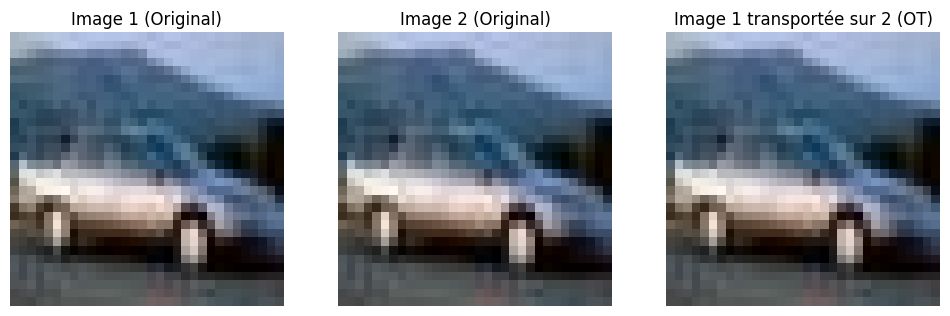


Sinkhorn UOT losses per channel :
  R: 0.000000
  G: 0.000000
  B: 0.000000


In [4]:
# --- 0. Définir le device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 1. Charger les images ---
try:
    img1_pil = Image.open("../data/cifar10/automobile/0000.jpg").convert("RGB")
    img2_pil = Image.open("../data/cifar10/automobile/0000.jpg").convert("RGB")
except FileNotFoundError:
    print("Erreur: Fichier image non trouvé. Assurez-vous que le chemin est correct.")
    # Créer des images dummy pour que le script tourne
    img1_pil = Image.fromarray(np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8))
    img2_pil = Image.fromarray(np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8))


# Convertir en tensor PyTorch (H,W,3) -> (3,H,W)
img1_raw = torch.from_numpy(np.array(img1_pil)).permute(2, 0, 1)
img2_raw = torch.from_numpy(np.array(img2_pil)).permute(2, 0, 1)

# --- 2. Appeler la reconstruction OT unbalanced ---
out = reconstruct_image_via_unbalanced_ot(
    img1_raw,
    img2_raw,
    res1=32,
    res2=32,
    blur=0.01,  # Flou (epsilon)
    reach=None,  # Portée (rho)
    p=2,
    debias=True,  # debias pour la loss, mais pas pour les potentiels
    device=DEVICE,
)

# Récupérer l'image reconstruite (3,H,W)
img_rec = out["reconstructed"]  # intensités reconstruites

# Normaliser pour l'affichage (si les intensités d'origine ne sont pas 0-1)
# Si vos images sont 0-255, la reconstruction barycentrique est aussi 0-255
if img1_raw.max() > 1.0:
    img_rec = img_rec / 255.0

img_rec = img_rec.clamp(min=0, max=1.0)  # sécurité
img_rec_np = img_rec.permute(1, 2, 0).numpy()

# Normaliser les images originales pour affichage si nécessaire
img1_np = img1_raw.permute(1, 2, 0).numpy()
img2_np = img2_raw.permute(1, 2, 0).numpy()
if img1_np.max() > 1.0:
    img1_np = img1_np / 255.0
if img2_np.max() > 1.0:
    img2_np = img2_np / 255.0


# --- 3. Afficher ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Image 1 (Original)")
plt.imshow(img1_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2 (Original)")
plt.imshow(img2_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Image 1 transportée sur 2 (OT)")
plt.imshow(img_rec_np)
plt.axis("off")

plt.show()

# --- Affichage des valeurs de coût par canal ---
print("\nSinkhorn UOT losses per channel :")
for c, v in out["losses"].items():
    print(f"  {c}: {v:.6f}")

In [8]:
import math  # we reuse math utilities for figure sizing

def _tensor_from_image(image: torch.Tensor | np.ndarray | Image.Image, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
    """Convert PIL/NumPy/Torch RGB image to (3,H,W) torch tensor on target device."""
    if isinstance(image, Image.Image):
        arr = np.array(image)
    elif isinstance(image, np.ndarray):
        arr = image
    else:
        arr = image  # already a torch tensor
    if isinstance(arr, np.ndarray):
        if arr.ndim == 3 and arr.shape[2] == 3:
            arr = torch.from_numpy(arr).permute(2, 0, 1)
        else:
            raise ValueError("NumPy images must be RGB with shape (H,W,3).")
    if not isinstance(arr, torch.Tensor) or arr.ndim != 3 or arr.shape[0] != 3:
        raise ValueError("Images must be RGB with shape (3,H,W) or (H,W,3).")
    return arr.to(device=device, dtype=dtype)
def _grid_positions_hw(height: int, width: int, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
    """Create [0,1]^2 grid ordered like torch.meshgrid(indexing='ij')."""
    ys = torch.linspace(0.0, 1.0, height, device=device, dtype=dtype)
    xs = torch.linspace(0.0, 1.0, width, device=device, dtype=dtype)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")
    return torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)

def _rasterize_channel(bary_positions: torch.Tensor, bary_weights: torch.Tensor, height: int, width: int) -> torch.Tensor:
    coords = bary_positions.clamp(min=0.0, max=0.9999)  # we keep coordinates within the grid
    xs = (coords[:, 0] * width).floor().long()  # we map x to pixel indices
    ys = (coords[:, 1] * height).floor().long()  # we map y to pixel indices
    indices = ys * width + xs  # we flatten indices for accumulation
    flat = torch.zeros(height * width, dtype=bary_weights.dtype, device=bary_weights.device)  # we initialize flat canvas
    flat.index_add_(0, indices, bary_weights)  # we add transported mass
    img = flat.view(height, width)  # we reshape to 2D channel
    img = img / img.max().clamp(min=1e-6)  # we normalize to [0,1]
    return img

def _compute_channel_barycenter(measures: list[tuple[torch.Tensor, torch.Tensor, float]], weights: list[float], blur: float, reach: float | None, backend: str) -> tuple[torch.Tensor, torch.Tensor]:
    if not math.isclose(sum(weights), 1.0, rel_tol=1e-6):
        raise ValueError("Interpolation weights must sum to 1.")
    ref_weights_raw, ref_positions, ref_mass = measures[0]
    device = ref_weights_raw.device
    dtype = ref_weights_raw.dtype
    ref_positions = ref_positions.detach().clone().requires_grad_(True)  # we enable gradients on reference grid
    num_points = ref_positions.shape[0]
    ref_uniform = torch.full((num_points,), 1.0 / num_points, device=device, dtype=dtype)  # we build uniform reference measure
    if reach is None:
        loss_fn = SamplesLoss(loss="sinkhorn", p=2, blur=blur, backend=backend)  # we use balanced formulation
    else:
        loss_fn = SamplesLoss(loss="sinkhorn", p=2, blur=blur, reach=reach, backend=backend)  # we use unbalanced formulation
    bary_positions_acc = torch.zeros_like(ref_positions)  # we accumulate barycentric positions
    bary_weights_acc = torch.zeros_like(ref_weights_raw)  # we accumulate barycentric weights
    total_mass = 0.0  # we accumulate target mass
    for lam, (weights_raw, positions, mass_val) in zip(weights, measures):
        weights_prob = weights_raw / weights_raw.sum().clamp(min=1e-6)  # we normalize to probability
        transport_cost = loss_fn(ref_uniform, ref_positions, weights_prob, positions)  # we compute divergence
        grad = torch.autograd.grad(transport_cost, ref_positions, retain_graph=True)[0]  # we differentiate w.r.t. positions
        monge = (ref_positions - grad / ref_uniform.unsqueeze(1)).detach()  # we approximate Monge map
        bary_positions_acc = bary_positions_acc + lam * monge  # we accumulate weighted positions
        bary_weights_acc = bary_weights_acc + lam * weights_prob  # we accumulate weighted probabilities
        total_mass = total_mass + lam * mass_val  # we track mass expectation
    bary_weights_acc = bary_weights_acc * total_mass  # we restore physical mass scale
    return bary_positions_acc, bary_weights_acc

def compute_rgb_channel_barycenter(
    images: list[torch.Tensor | np.ndarray],
    lambdas: list[float],
    blur: float,
    reach: float | None,
    target_resolution: int | tuple[int, int],
    device: str = "cpu",
    backend: str = "tensorized",
) -> torch.Tensor:
    if len(images) != len(lambdas):
        raise ValueError("The number of images must match the number of weights.")
    device_obj = torch.device(device)
    dtype = torch.float32
    processed = []
    for image in images:
        tensor = _tensor_from_image(image, device_obj, dtype)  # we convert image to tensor
        tensor = _downsample_to_resolution(tensor, target_resolution)  # we match requested resolution
        processed.append(tensor)
    height, width = processed[0].shape[1], processed[0].shape[2]
    positions_grid = _grid_positions_hw(height, width, device_obj, dtype)  # we build reference grid
    bary_channels = []
    for channel_index in range(3):
        measures = []
        for tensor in processed:
            positions, weights = _channel_to_measure(tensor[channel_index], device=device_obj)  # we recover channel measure
            mass_val = float(weights.sum().item())  # we record channel mass
            measures.append((weights.to(device_obj, dtype=dtype), positions.to(device_obj, dtype=dtype), mass_val))
        bary_positions, bary_weights = _compute_channel_barycenter(measures, lambdas, blur, reach, backend)  # we compute barycenter
        channel_img = _rasterize_channel(bary_positions, bary_weights, height, width)  # we rasterize barycentric result
        bary_channels.append(channel_img)
    bary_stack = torch.stack(bary_channels, dim=0)  # we stack channels into RGB tensor
    return bary_stack.clamp(0.0, 1.0)

def plot_barycenter_grid(
    source_image: torch.Tensor | np.ndarray,
    target_image: torch.Tensor | np.ndarray,
    blur_values: list[float],
    reach_values: list[float | None],
    t_values: list[float],
    target_resolution: int | tuple[int, int],
    device: str = "cpu",
    backend: str = "tensorized",
    figsize_base: float = 3.5,
) -> None:
    for t_val in t_values:
        fig, axes = plt.subplots(len(reach_values), len(blur_values), figsize=(figsize_base * len(blur_values), figsize_base * len(reach_values)))
        if len(reach_values) == 1:
            axes = np.expand_dims(axes, axis=0)
        if len(blur_values) == 1:
            axes = np.expand_dims(axes, axis=1)
        title = f"Barycenters per channel | t={t_val:.2f}"
        fig.suptitle(title, fontsize=14)
        for row_idx, reach_val in enumerate(reach_values):
            for col_idx, blur_val in enumerate(blur_values):
                bary_rgb = compute_rgb_channel_barycenter(
                    images=[source_image, target_image],
                    lambdas=[1.0 - t_val, t_val],
                    blur=blur_val,
                    reach=reach_val,
                    target_resolution=target_resolution,
                    device=device,
                    backend=backend,
                )
                ax = axes[row_idx][col_idx]
                ax.imshow(bary_rgb.permute(1, 2, 0).detach().cpu().numpy())
                reach_str = "∞" if reach_val is None else f"{reach_val:g}"
                ax.set_title(f"ρ={reach_str} | ε={blur_val:g}", fontsize=10)
                ax.axis("off")
        plt.tight_layout()
        plt.show()

KeyboardInterrupt: 

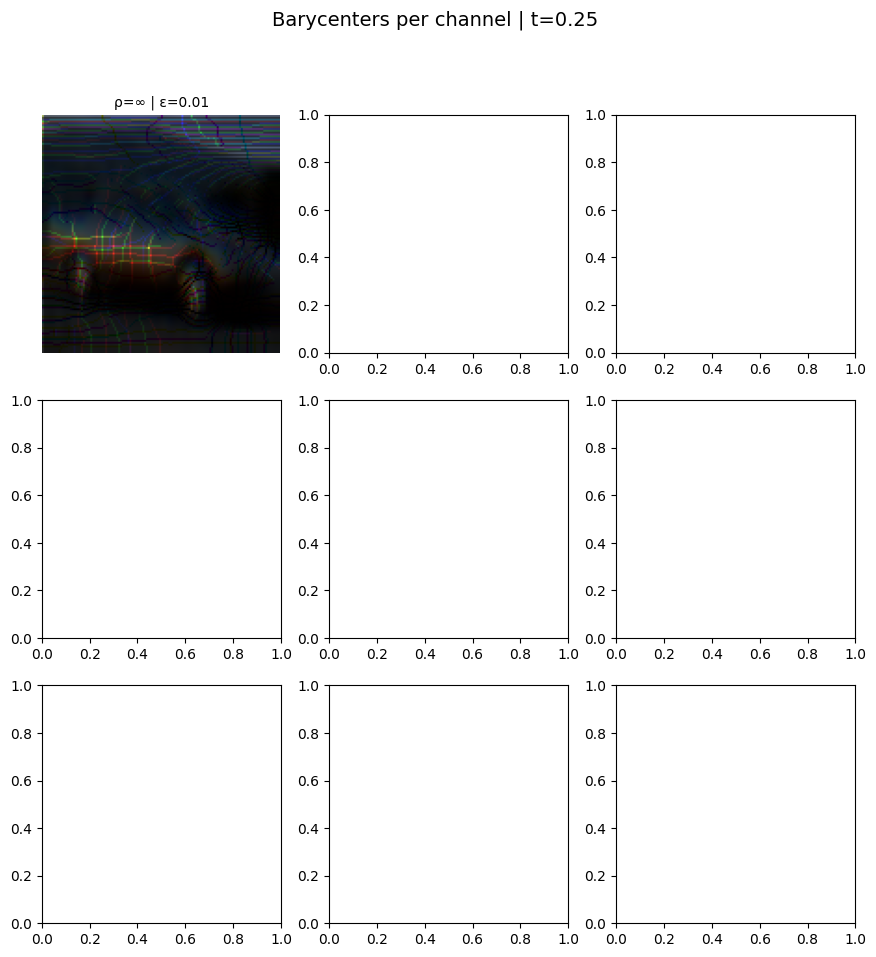

In [9]:
source = Image.open("../data/cifar10/automobile/0000.jpg").convert("RGB")
target = Image.open("../data/cifar10/automobile/0000.jpg").convert("RGB")
plot_barycenter_grid(
    source_image=source,
    target_image=target,
    blur_values=[0.01, 0.05, 0.1],
    reach_values=[None, 0.1, 1.0],
    t_values=[0.25, 0.5, 0.75],
    target_resolution=128,
    device=DEVICE,          # reuse the notebook’s device setting
    backend="tensorized",
    figsize_base=3.5,
)
